In [28]:
! nvidia-smi

Wed Jan 17 12:36:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5500               On  | 00000000:51:00.0 Off |                  Off |
| 30%   35C    P8              19W / 230W |  24036MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # second gpu
# from tensorflow.compat.v1.keras.backend import get_session

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# tf.compat.v1.disable_v2_behavior()  # breaks
# tf.compat.v1.enable_eager_execution()

2024-01-17 12:24:05.063681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 12:24:05.838527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


In [3]:
# ! pip uninstall windowshap -y

# In terminal: 
# conda activate mozo2env311
# conda config --add channels conda-forge
# conda install -y pandas numpy scikit-learn shap lime aeon keras ruptures tslearn python-graphviz 
# conda install -y pytorch torchvision torchaudio cudatoolkit -c pytorch -c conda-forge  ## =11.1

# Add new kernel for GPU: 
# python -m ipykernel install --user --name mozo2env311 --display-name "Python 3.11 mozo2 env" \
#   --env LD_LIBRARY_PATH "$LD_LIBRARY_PATH" \
#   --env CONDA_PREFIX "$CONDA_PREFIX" \
#   --env XLA_FLAGS " --xla_gpu_cuda_data_dir=$CONDA_PREFIX"

# pip install kshape

In [76]:
# Szymon: shap                          0.42.1
! conda list | grep shap

kshape                    1.0.6                    pypi_0    pypi
shap                      0.44.0          cuda118py311h54bb65a_7    conda-forge


In [29]:
import keras
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import shap

from aeon.datasets import load_classification
from collections import deque
from scipy.signal import butter, filtfilt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.layers import Dense, Flatten, Dropout, LSTM, Bidirectional, Reshape, Input, TimeDistributed, RepeatVector, \
    ConvLSTM1D, Conv1DTranspose, Conv1D
from keras.models import Model, Sequential
from keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [4]:
ls shared

comparison.svg          metropt/      shared-metro.zip         Untitled1.ipynb
convlstm-metropt.ipynb  proto.tar.gz  summaryMultivariate.csv  Untitled.ipynb
dtw-vs-no-dtw/          ProtoTSNet/   summaryUnivariate.csv    windowshap/
gpu_users.sh*           README.txt    tsproto/


In [5]:
%cd shared
from windowshap.windowshap import SlidingWindowSHAP
from tsproto.tsproto import outliers
%cd ..

/home/jovyan/shared
/home/jovyan


using dhist requires you to install the `pickleshare` library.


# Real Data example

In [7]:
# convlstm model
def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i * i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor


def load_dataset_aeon(dsname):
    X, y, meta_data = load_classification(dsname)
    X = np.moveaxis(X, 1, 2)

    le = LabelEncoder()
    y = le.fit_transform(y)
    trainX, testX, trainy, testy = train_test_split(X, y)

    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    return trainX, trainy, testX, testy


# fit and evaluate a model
def train_model(trainX, trainy, testX, testy, encoder):
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    # reshape into subsequences (samples, time steps, rows, cols, channels)

    dg = divisorGenerator(n_timesteps)
    n_steps = int([next(dg) for i in range(3)][-1])
    n_length = int(n_timesteps // n_steps)

    inputs = Input(shape=(trainX.shape[1:]))
    embedding = encoder(inputs)
    dropout = Dropout(0.5)(embedding)
    x = Flatten(name='embedding')(dropout)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy, model


def train_lstmconv_ae(trainX, testX, kernel=11):
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    # reshape into subsequences (samples, time steps, rows, cols, channels)

    dg = divisorGenerator(n_timesteps)
    n_steps = int([next(dg) for i in range(3)][-1])
    n_length = int(n_timesteps // n_steps)
    #n_steps, n_length = 4, 32 #todo this has to be dividers of trainX.shape[1]
    #trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    #testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    print(f'Input shape (time, rows, channels): {(n_steps, n_length, n_features)}')
    model = Sequential()
    model.add(Reshape((n_steps, n_length, n_features), input_shape=trainX.shape[1:]))
    model.add(ConvLSTM1D(filters=64, kernel_size=kernel, padding='same', activation='relu', strides=1,
                         data_format='channels_last',
                         return_sequences=True,
                         input_shape=(n_steps, n_length, n_features)))
    model.add(ConvLSTM1D(filters=32, kernel_size=kernel, padding='same', activation='relu', strides=1,
                         data_format='channels_last',
                         return_sequences=True,
                         input_shape=(n_steps, n_length, n_features)))
    model.add(Dropout(0.5))
    model.add(
        TimeDistributed(Conv1DTranspose(filters=32, kernel_size=kernel, padding='same', activation='relu', strides=1)))
    model.add(
        TimeDistributed(Conv1DTranspose(filters=64, kernel_size=kernel, padding='same', activation='relu', strides=1)))
    model.add(TimeDistributed(Conv1DTranspose(filters=n_features, kernel_size=kernel, padding='same', strides=1)))
    model.add(Reshape((n_steps * n_length, n_features)))

    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    # print(model.summary())  # TODO it breaks
    # fit network
    model.fit(trainX, trainX, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, mse = model.evaluate(testX, testX, batch_size=batch_size, verbose=0)
    return mse, model


def train_lstmconv_ae_functional(trainX, testX, kernel=11):
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    # reshape into subsequences (samples, time steps, rows, cols, channels)

    dg = divisorGenerator(n_timesteps)
    n_steps = int([next(dg) for i in range(3)][-1])
    n_length = int(n_timesteps // n_steps)
    #n_steps, n_length = 4, 32 #todo this has to be dividers of trainX.shape[1]
    #trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    #testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    print(f'Input shape (time, rows, channels): {(n_steps, n_length, n_features)}')
    inputs = Input(shape=(trainX.shape[1:]))
    r = Reshape((n_steps, n_length, n_features), input_shape=trainX.shape[1:])(inputs)
    encoder = ConvLSTM1D(filters=64, kernel_size=kernel, padding='same', activation='relu', strides=1,
                         data_format='channels_last',
                         return_sequences=True,
                         input_shape=(n_steps, n_length, n_features))(r)
    encoder = ConvLSTM1D(filters=32, kernel_size=kernel, padding='same', activation='relu', strides=1,
                         data_format='channels_last',
                         return_sequences=True,
                         input_shape=(n_steps, n_length, n_features))(encoder)

    dropout = Dropout(0.5)(encoder)

    decoder = TimeDistributed(
        Conv1DTranspose(filters=32, kernel_size=kernel, padding='same', activation='relu', strides=1))(dropout)
    decoder = TimeDistributed(
        Conv1DTranspose(filters=64, kernel_size=kernel, padding='same', activation='relu', strides=1))(decoder)
    decoder = TimeDistributed(
        Conv1DTranspose(filters=n_features, kernel_size=kernel, padding='same', strides=1, activation='linear'))(
        decoder)
    output = Reshape((n_steps * n_length, n_features))(decoder)

    model = Model(inputs=inputs, outputs=output)

    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    # print(model.summary())  # TODO it breaks
    # fit network
    model.fit(trainX, trainX, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, mse = model.evaluate(testX, testX, batch_size=batch_size, verbose=0)

    #save encoder

    encoder_model = Model(inputs=inputs, outputs=encoder)
    encoder_model.save(f'results/metropt/model_lstmconv_encoder.h5', save_format='h5')
    return mse, model, encoder_model


def train_conv_ae(trainX, testX):
    verbose, epochs, batch_size = 0, 25, 64
    model = keras.Sequential([
        Input(shape=(trainX.shape[1], trainX.shape[2])),
        Conv1D(
            filters=128, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        Dropout(rate=0.2),
        Conv1D(
            filters=64, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        Conv1DTranspose(
            filters=64, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        Dropout(rate=0.2),
        Conv1DTranspose(
            filters=128, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        Conv1DTranspose(filters=trainX.shape[2], kernel_size=7, padding="same"),
    ])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    # fit network
    model.fit(trainX, trainX, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, mse = model.evaluate(testX, testX, batch_size=batch_size, verbose=0)
    return mse, model


def train_lstm_ae(trainX, testX):
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]
    model = keras.Sequential([
        Input(shape=(n_timesteps, n_features)),
        Bidirectional(LSTM(128, activation='relu')),
        RepeatVector(n_timesteps),
        Dropout(0.5),
        Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
        TimeDistributed(Dense(20))
    ])

    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    # fit network
    model.fit(trainX, trainX, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, mse = model.evaluate(testX, testX, batch_size=batch_size, verbose=0)
    return mse, model


def save_bundle(model, trainX, trainy, testX, testy, svtr, svts, dsname, dir='./results'):
    if not os.path.isdir(f'{dir}/{dsname}'):
        os.makedirs(f'{dir}/{dsname}')

    model.save(f'{dir}/{dsname}/model.h5', save_format='h5')
    pickle.dump(trainX, open(f'{dir}/{dsname}/trainX.pickle', 'wb'))
    pickle.dump(trainy, open(f'{dir}/{dsname}/trainy.pickle', 'wb'))
    pickle.dump(testX, open(f'{dir}/{dsname}/testX.pickle', 'wb'))
    pickle.dump(testy, open(f'{dir}/{dsname}/testy.pickle', 'wb'))
    pickle.dump(svtr, open(f'{dir}/{dsname}/svtr.pickle', 'wb'))
    pickle.dump(svts, open(f'{dir}/{dsname}/svts.pickle', 'wb'))


def load_bundle(dsname, dir='./results'):
    model = keras.models.load_model(f'{dir}/{dsname}/model.h5')

    trainX = pickle.load(open(f'{dir}/{dsname}/trainX.pickle', 'rb'))
    trainy = pickle.load(open(f'{dir}/{dsname}/trainy.pickle', 'rb'))
    testX = pickle.load(open(f'{dir}/{dsname}/testX.pickle', 'rb'))
    testy = pickle.load(open(f'{dir}/{dsname}/testy.pickle', 'rb'))
    svtr = pickle.load(open(f'{dir}/{dsname}/svtr.pickle', 'rb'))
    svts = pickle.load(open(f'{dir}/{dsname}/svts.pickle', 'rb'))

    return model, trainX, trainy, testX, testy, svtr, svts


def butter_lowpass_filter(data, cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


def exponential_smoothing(series, alpha):
    """
    Perform exponential smoothing on a pandas Series.

    Parameters:
    series (pd.Series): Input time series as a pandas Series.
    alpha (float): Smoothing parameter (0 < alpha < 1).

    Returns:
    pd.Series: Exponentially smoothed time series.
    """
    smoothed_values = [series.iloc[0]]  # Initialize with the first value
    for t in range(1, len(series)):
        smoothed_value = alpha * series.iloc[t] + (1 - alpha) * smoothed_values[-1]
        smoothed_values.append(smoothed_value)

    return pd.Series(smoothed_values, index=series.index)

## Metro PT


In [8]:
! ls

AreaOccupied.csv	    results
auxiliary_mushrooms.py	    secondary+mushroom+dataset.zip
auxiliary_somerville.py     secondary+mushroom+dataset.zip.1
auxilliary_eval_classes.py  serialised
bi8e-5vw8.csv		    shared
example.json		    slow
fast			    SomervilleHappinessSurvey2015.csv
fibbonaci_50.csv	    Somerville_Happiness_Survey_Responses.csv
figures			    Somerville_Happiness_Survey_Responses.zip
first-used.json		    somerville+happiness+survey.zip
food_specifications.csv     somerville+happiness+survey.zip.1
imgs			    somerville+happiness+survey.zip.2
lux			    SportsAchivements.csv
MushroomDataset		    temp.txt
MushroomDataset.zip	    tree-cf-visual.dot
nations.txt		    tree.png
printing.txt		    tree-pure.dot
__pycache__		    try.png
README.txt		    uniform_random_50.csv


In [9]:
resampling = '60s'
metro_o = pd.read_csv('shared/metropt/dataset_train.csv')
features_o = [f for f in metro_o.columns if f not in ['gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']]
metro_o = metro_o[features_o]
#toido: groupby 60 sek, mean,

In [10]:
metro_o['timestamp'] = metro_o['timestamp'].astype('datetime64[ns]')
if resampling is not None:
    metro = metro_o.set_index('timestamp').resample(resampling).mean().reset_index().dropna()
else:
    metro = metro_o

In [11]:
mms = MinMaxScaler()
healthy = metro[metro['timestamp'] < '2022-02-01']
features = [f for f in healthy if f not in ['timestamp', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']]
healthy.loc[:, features] = mms.fit_transform(healthy[features])

In [12]:
window = 30
stride = 1  #todo or make it lambda random form a range 1-5?
start = 0
X = list()
while start + window <= healthy.shape[0]:
    X.append(healthy.iloc[start:start + window, 1:].T.values)
    start = start + stride

In [13]:
healthyX = np.moveaxis(np.array(X), 1, -1)

In [14]:
healthyX.shape

(37064, 30, 16)

In [15]:
trainX, testX = train_test_split(healthyX, test_size=0.1)

In [16]:
err_lstmconv_ae, model_lstmconv_ae, encoder = train_lstmconv_ae_functional(trainX, trainX)
model_lstmconv_ae.save(f'shared/metropt/model_lstmconv_ae_v2.h5', save_format='h5')
encoder.save(f'shared/metropt/model_lstmconv_encoder_v2.h5', save_format='h5')

Input shape (time, rows, channels): (3, 10, 16)


2024-01-17 12:24:51.818615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22203 MB memory:  -> device: 0, name: NVIDIA RTX A5500, pci bus id: 0000:9c:00.0, compute capability: 8.6
2024-01-17 12:24:56.294955: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562031db1e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 12:24:56.295014: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5500, Compute Capability 8.6
2024-01-17 12:24:56.444854: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-17 12:24:57.255388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-17 12:24:57.438453: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn 

0.0004451775748748332

In [18]:
err_lstmconv_ae

0.0004451775748748332

In [ ]:
model_lstmconv_ae = load_model('shared/metropt/model_lstmconv_ae_v2.h5')
encoder = load_model('shared/metropt/model_lstmconv_encoder_v2.h5')

In [30]:
1 + 1

2

## Detect anomalies by plotting reconstruction error

In [19]:
realdata = metro[metro['timestamp'] >= '2022-02-01']
realdata.loc[:, features] = mms.transform(realdata[features])
stride = window  #for test data we do not need overlapping
start = 0
X = list()
timestamps = list()
while start + window <= realdata.shape[0]:
    X.append(realdata.iloc[start:start + window, 1:].T.values)
    timestamps.append(realdata.iloc[start].timestamp)
    start = start + stride
realX = np.moveaxis(np.array(X), 1, -1)

In [20]:
reconstructedRealX = model_lstmconv_ae.predict(realX)
#reconstructedRealX = model_lstm_ae.predict(realX)
#reconstructedRealX = model_conv_ae.predict(realX)

149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [21]:
reconstructedRealX.shape

(4753, 30, 16)

In [22]:
recerr = (reconstructedRealX - realX)

In [23]:
recerr.shape

(4753, 30, 16)

In [24]:
recerr_agg = np.mean(np.mean(np.abs(recerr), axis=1), axis=1)
recerr_agg_idx = np.argmax(np.mean(np.abs(recerr), axis=1), axis=1)

In [49]:
recerr_agg_df = pd.DataFrame({'timestamp': timestamps, 'erro': recerr_agg})

In [50]:
recerr_agg_df['err'] = recerr_agg_df['erro']
#recerr_agg_df['err'] = butter_lowpass_filter(recerr_agg_df['erro'], cutoff =5 , fs=1000)
recerr_agg_df['err'] = exponential_smoothing(recerr_agg_df['erro'], alpha=0.5)

In [51]:
i, l, u = outliers(recerr_agg_df['err'], multiplier=1.5)

In [52]:
i

0.004634910489446158

In [53]:
err = recerr_agg_df.set_index('timestamp')

(array([19024., 19038., 19052., 19066., 19083., 19097., 19113., 19127.,
        19144.]),
 [Text(19024.0, 0, '2022-02-01'),
  Text(19038.0, 0, '2022-02-15'),
  Text(19052.0, 0, '2022-03-01'),
  Text(19066.0, 0, '2022-03-15'),
  Text(19083.0, 0, '2022-04-01'),
  Text(19097.0, 0, '2022-04-15'),
  Text(19113.0, 0, '2022-05-01'),
  Text(19127.0, 0, '2022-05-15'),
  Text(19144.0, 0, '2022-06-01')])

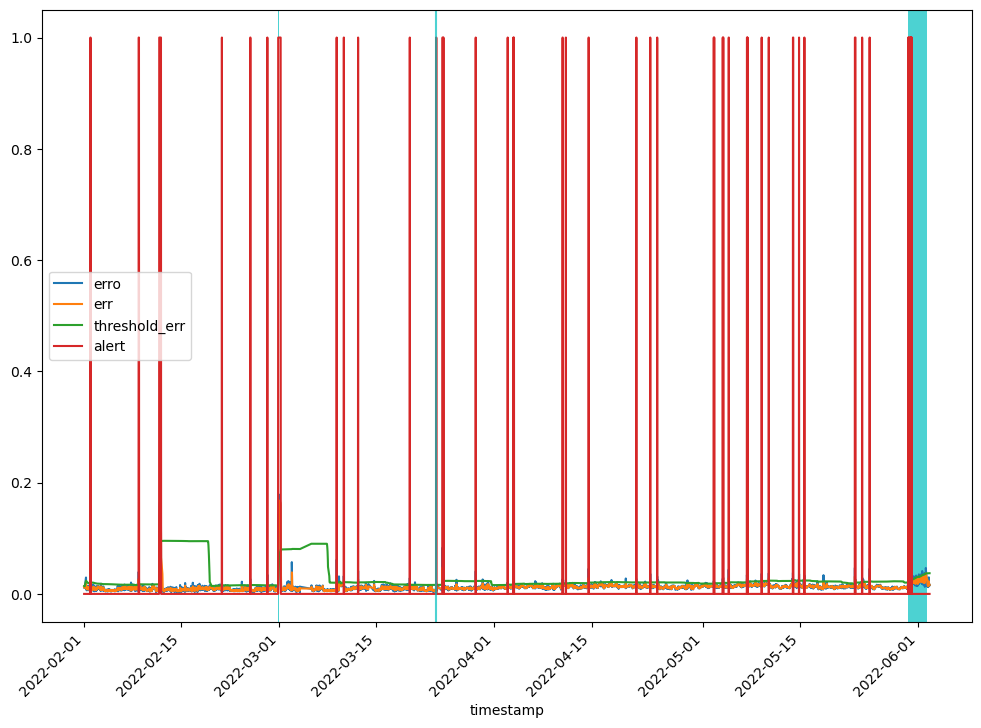

In [54]:
#TODO: mask anomalies that have been previously detected as anomalies
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

rolling_buffer = '7d'

recerr_agg_df['timestamp'] = recerr_agg_df['timestamp'].astype('datetime64[ns]')

err.loc[:, "threshold_err"] = (err.rolling(rolling_buffer).mean() + 3 * err.rolling(rolling_buffer).std())['err']
err['alert'] = (err['err'] > err['threshold_err']).astype(int)  #/2
err.plot(ax=ax)
ax.axvspan('2022-02-28 21:53:00', '2022-03-01 02:00:00', facecolor='c', alpha=0.7)
ax.axvspan('2022-03-23 14:54:00', '2022-03-23 15:24:00', facecolor='c', alpha=0.7)
ax.axvline('2022-03-23 14:54:00', color='c', alpha=0.7)
ax.axvspan('2022-05-30 12:00:00', '2022-06-02 06:18:00', facecolor='c', alpha=0.7)
plt.xticks(rotation=45)

In [55]:
err[err['alert'] > 0].shape

(96, 4)

(array([19024., 19038., 19052., 19066., 19083., 19097., 19113., 19127.,
        19144.]),
 [Text(19024.0, 0, '2022-02-01'),
  Text(19038.0, 0, '2022-02-15'),
  Text(19052.0, 0, '2022-03-01'),
  Text(19066.0, 0, '2022-03-15'),
  Text(19083.0, 0, '2022-04-01'),
  Text(19097.0, 0, '2022-04-15'),
  Text(19113.0, 0, '2022-05-01'),
  Text(19127.0, 0, '2022-05-15'),
  Text(19144.0, 0, '2022-06-01')])

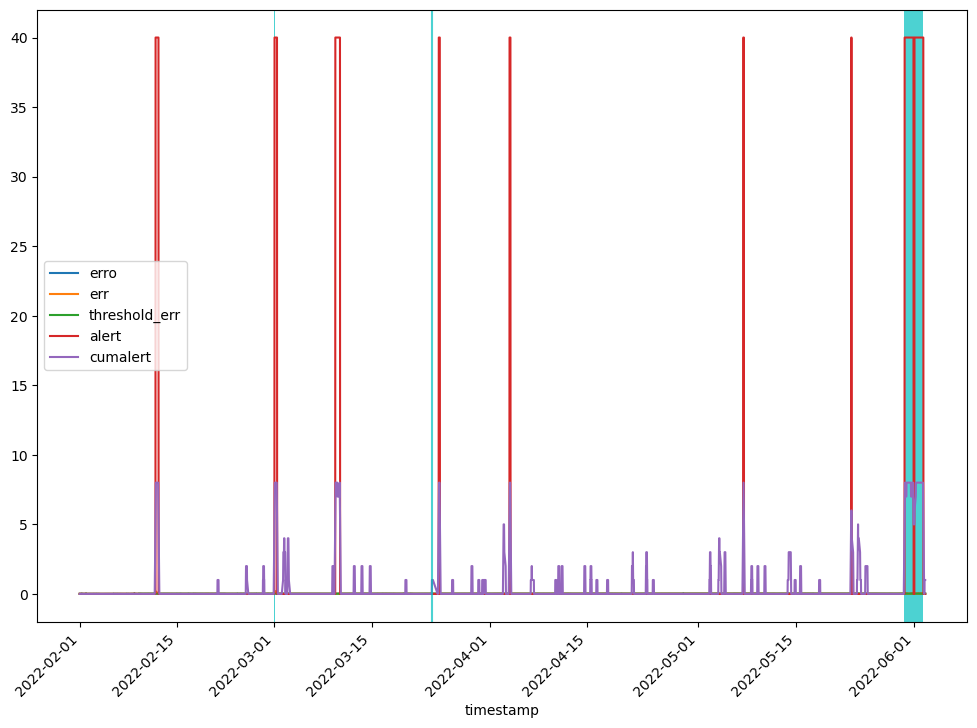

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

rolling_buffer = '7d'

err.loc[:, "threshold_err"] = 0
err.loc[:, "alert"] = 0
err.loc[:, "cumalert"] = 0
bufflen = int(2 * 24 * 7)  #sampels_per_hour * 24 * days
buffer = deque(maxlen=bufflen)
abufflen = int(2 * 4)  #samples_per_hour * monitoring_hours
alertbuf = deque(maxlen=abufflen)
for i, r in err.iterrows():
    if len(buffer) < bufflen:
        buffer.append(r['err'])
        continue
    avg = np.mean(buffer)
    sigma = np.std(buffer)
    if r['err'] > avg + 3 * sigma:
        err.loc[i, 'alert'] = 1
        alertbuf.append(1)
    else:
        alertbuf.append(0)
        buffer.append(r['err'])
    err.loc[i, 'cumalert'] = sum(alertbuf)

    if sum(alertbuf) >= 0.75 * abufflen:
        err.loc[i, 'alert'] = 40
    else:
        err.loc[i, 'alert'] = 0
    err.loc[i, "threshold_err"] = avg + 3 * sigma

err.plot(ax=ax)
ax.axvspan('2022-02-28 21:53:00', '2022-03-01 02:00:00', facecolor='c', alpha=0.7)
ax.axvspan('2022-03-23 14:54:00', '2022-03-23 15:24:00', facecolor='c', alpha=0.7)
ax.axvline('2022-03-23 14:54:00', color='c', alpha=0.7)
ax.axvspan('2022-05-30 12:00:00', '2022-06-02 06:18:00', facecolor='c', alpha=0.7)
plt.xticks(rotation=45)

([<matplotlib.axis.YTick at 0x7f4b3d008f10>,
 [Text(0, 0, 'TP2'),
  Text(0, 1, 'TP3'),
  Text(0, 2, 'H1'),
  Text(0, 3, 'DV_pressure'),
  Text(0, 4, 'Reservoirs'),
  Text(0, 5, 'Oil_temperature'),
  Text(0, 6, 'Flowmeter'),
  Text(0, 7, 'Motor_current'),
  Text(0, 8, 'COMP'),
  Text(0, 9, 'DV_eletric'),
  Text(0, 10, 'Towers'),
  Text(0, 11, 'MPG'),
  Text(0, 12, 'LPS'),
  Text(0, 13, 'Pressure_switch'),
  Text(0, 14, 'Oil_level'),
  Text(0, 15, 'Caudal_impulses')])

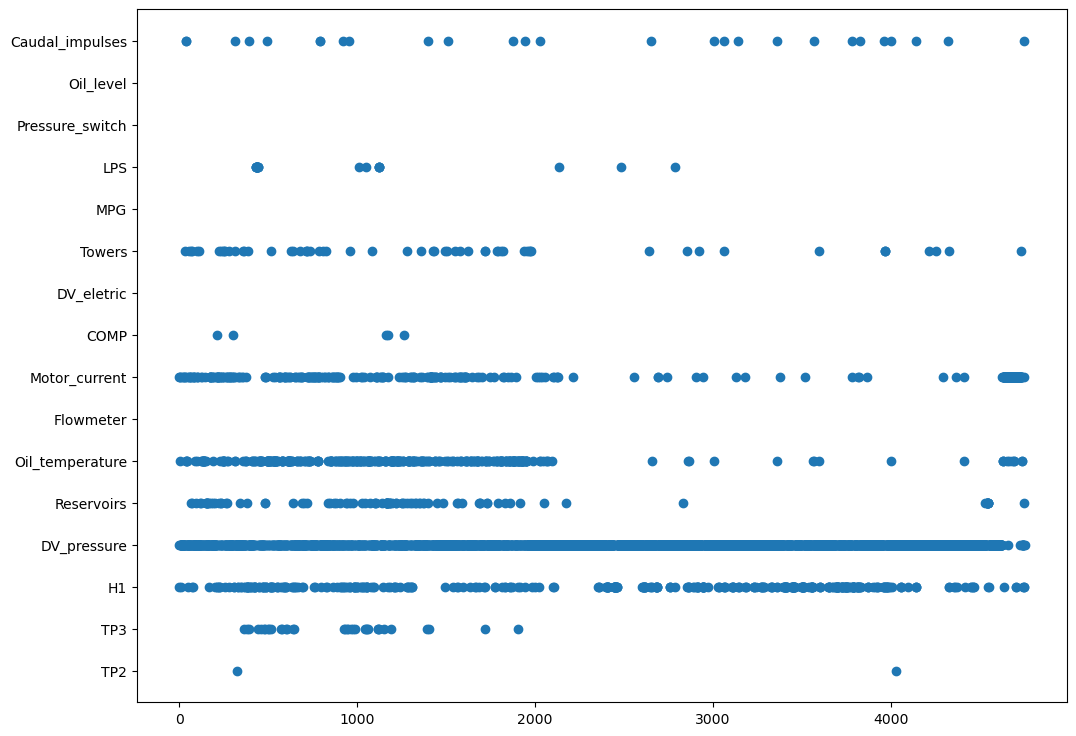

In [57]:
#last results form window of 180, 128 units, kernels 16-size (previously kernels 7)
plt.figure(figsize=(12, 9))
plt.scatter(np.arange(0, len(recerr_agg_idx)), recerr_agg_idx)
ticks = realdata.columns[1:]
plt.yticks(np.arange(len(ticks)), ticks)

In [58]:
recerr_agg = np.mean(np.mean(np.abs(recerr), axis=1), axis=1)

In [59]:
sensor_err = np.mean(np.abs(recerr), axis=1)
sensorerr_agg_df = pd.DataFrame(sensor_err, columns=features)
sensorerr_agg_df['timestamp'] = timestamps
sensorerr_agg_df = sensorerr_agg_df.set_index('timestamp')

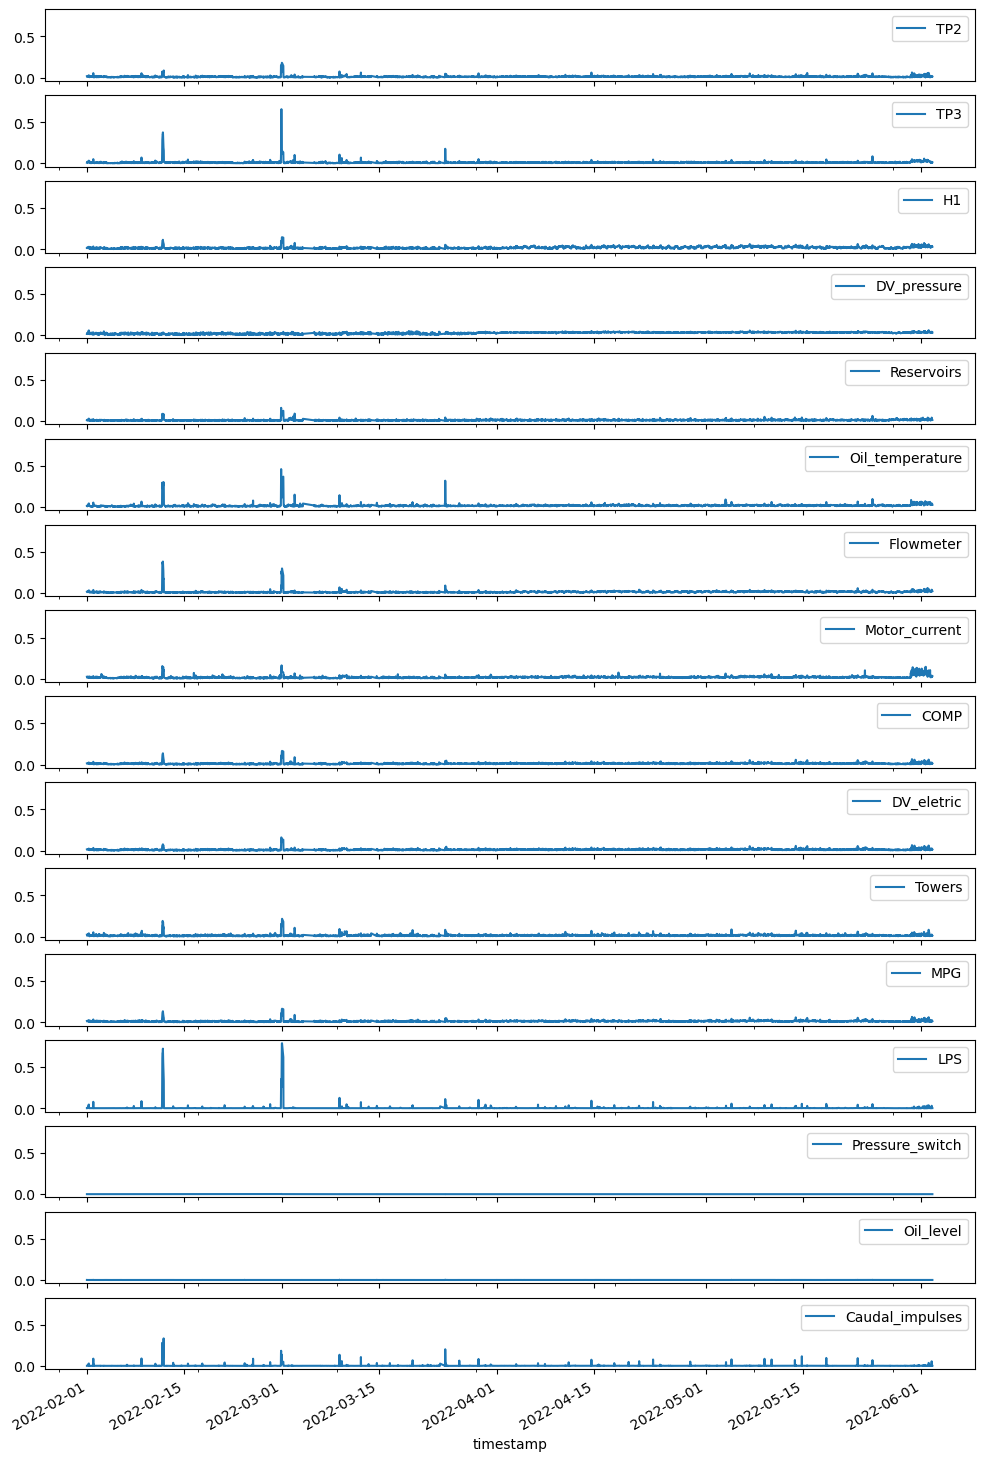

In [60]:
fig, axs = plt.subplots(len(features), figsize=(12, 20), sharex=True, sharey=True)
for i, f in enumerate(features):
    sensorerr_agg_df[[f]].plot(ax=axs[i])

## Classifier

In [61]:
breaks = err['alert'] - err['alert'].shift(-1)
separate_alerts = breaks[breaks < 0]

In [62]:
separate_alerts

timestamp
2022-02-11 21:19:00   -40.0
2022-03-01 00:02:00   -40.0
2022-03-09 17:57:00   -40.0
2022-03-24 15:03:00   -40.0
2022-04-03 19:24:00   -40.0
2022-05-07 10:20:00   -40.0
2022-05-22 23:05:00   -40.0
2022-05-30 15:27:00   -40.0
2022-06-01 01:26:00   -40.0
Name: alert, dtype: float64

In [63]:
erri = err.reset_index()
Xerr = erri[erri['alert'] > 0]
Xset = erri[erri['cumalert'] == 0].sample(len(Xerr))

In [64]:
dsidxerr = list(Xerr.index)
dsixnormal = list(Xset.index)

In [65]:
cl_inputX = np.concatenate((realX[dsidxerr, :, :], realX[dsixnormal, :, :]))
cl_inputy = to_categorical(np.concatenate((np.ones(len(Xerr)), np.zeros(len(Xset)))))

In [66]:
fXtrain, fXtest, ftrainy, ftesty = train_test_split(cl_inputX, cl_inputy, shuffle=False)

In [67]:
encoder.trainable = True

In [68]:
encoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 16)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ reshape (Reshape)               │ (None, 3, 10, 16)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv_lstm1d (ConvLSTM1D)        │ (None, 3, 10, 64)         │    225,536 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv_lstm1d_1 (ConvLSTM1D)      │ (None, 3, 10, 32)         │    135,296 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 360,832 (1.38 MB)

 Trainable params: 360,832 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
accuracy, model = train_model(fXtrain, ftrainy, fXtrain, ftrainy,
                              encoder)  #same data, because we just want to interpret what has been learnt

In [70]:
accuracy

0.99609375

In [71]:
predicted = model.predict(fXtrain)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  


In [72]:
f1_score(np.argmax(ftrainy, axis=1), np.argmax(predicted, axis=1))

0.9970674486803519

### Shap

In [77]:
shap_version = 'deep'
bg_size = 1000
absshap = True
# window_len = -1  # TODO only for SlidingWindowSHAP
# if shap_version == 'window':
#     #There is a problem with Windowed version for more than two classes
#     indexes = np.arange(0, len(fXtrain))
#     np.random.shuffle(indexes)
#     maxid = min(bg_size, len(fXtrain))
#     background_data = fXtrain[indexes[:maxid]]
# 
#     sv_ts = np.zeros((len(fXtrain), fXtrain.shape[1], fXtrain.shape[2]))
#     sv_tr = np.zeros((len(fXtrain), fXtrain.shape[1], fXtrain.shape[2]))
# 
#     for i in range(len(fXtrain)):
#         gtw = SlidingWindowSHAP(model, stride, window_len, background_data, fXtrain[i:i + 1], model_type='lstm')
#         sv_ts[i, :, :] = gtw.shap_values(num_output=ftrainy.shape[1])
#     for i in range(len(fXtrain)):
#         gtw = SlidingWindowSHAP(model, stride, window_len, background_data, fXtrain[i:i + 1], model_type='lstm')
#         sv_tr[i, :, :] = gtw.shap_values(num_output=ftrainy.shape[1])
if shap_version == 'deep':
    indexes = np.arange(0, len(fXtrain))
    np.random.shuffle(indexes)
    maxid = min(bg_size, len(fXtrain))
    background_data = fXtrain[indexes[:maxid]]

    explainer = shap.DeepExplainer(model, background_data)
    shap_values_ts = explainer.shap_values(fXtrain, check_additivity=False)
    shap_values_tr = explainer.shap_values(fXtrain, check_additivity=False)
    if absshap:
        sv_ts = abs(np.array(shap_values_ts)).mean(
            axis=0)  # This basically returns the average importance over the feature/sample
        # Not taking into account the sign of shap value, as it is not required
        # for breakpoints calculation
        sv_tr = abs(np.array(shap_values_tr)).mean(
            axis=0)  # This basically returns the average importance over the feature/sample
        # Not taking into account the sign of shap value, as it is not required
        # for breakpoints calculation
    else:
        indexer = np.argmax(model.predict(fXtrain), axis=1)
        sv_ts = []
        for i in range(0, len(fXtrain)):
            sv_ts.append([shap_values_ts[indexer[i]][i, :]])
        sv_ts = np.concatenate(sv_ts)
        indexer = np.argmax(model.predict(fXtrain), axis=1)
        sv_tr = []
        for i in range(0, len(fXtrain)):
            sv_tr.append([shap_values_tr[indexer[i]][i, :]])
        sv_tr = np.concatenate(sv_tr)

ValueError: <class 'keras.models.functional.Functional'> is not currently a supported model type!